In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import mlab

In [3]:
df_domains = pd.read_csv('data/domain.csv',sep=',', encoding='latin1', keep_default_na=False)
df_links = pd.read_csv('data/links.csv',sep='|', encoding='latin1', keep_default_na=False)

## Distribution of news websites using AMP

This is the distribution of AMP-enabled vs non AMP-enabled websites in Africa. Out of the 56 countries and territories surveyed in Africa, 40 (71.5%) have at least one of their news website running on AMP. Out of 1431 domains collected, 194 domains are AMP-enabled i.e. around 13.5%. This represents quite a significant level of popularity of the AMP platform on the continent. The countries with the highest number of AMP-enabled news websites are KE, ZM, NG and ZA. Figure below shows a distribution of AMP vs Non-AMP websites by country, where there is at least 2 AMP-enabled domains.


In [4]:
z = []
for index, row in df_domains.iterrows():
    z.append(len(df_links.loc[df_links.domain==row['domain']]))
df_domains['amp_links_count'] = z

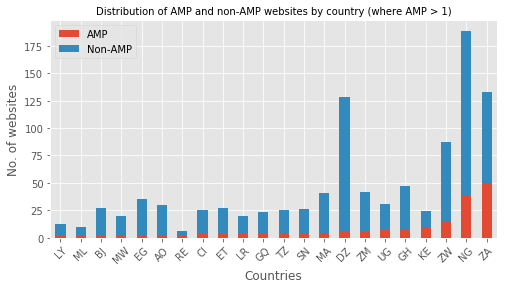

In [45]:
df1 = df_domains.iloc[:,[2,12]]
non_amp_domains = df1.loc[df1.amp_links_count == 0].groupby('cc').size()
amp_enabled_domains = df1.loc[df1.amp_links_count > 0].groupby('cc').size()

df2 = pd.DataFrame(columns=['cc','AMP','Non-AMP'])

for cc in df1['cc'].drop_duplicates():
    non_amp_size = 0
    amp_size = 0
    
    try:
        non_amp_size = non_amp_domains[cc]
        amp_size = amp_enabled_domains[cc]
    except KeyError:
        pass
    
    df2 = df2.append({'cc':cc, 'AMP': amp_size, 'Non-AMP':  non_amp_size}, ignore_index=True)
    
#df2['total'] = df2.apply(lambda row: row['AMP'] + row['Non-AMP'], axis=1)
#df2 = df2.iloc[:,[0,1,3]]

df2 = df2.loc[df2['AMP']>1].sort_values(by='AMP', ascending=True)

ax = df2.plot.bar(stacked=True, figsize=(8,4), x='cc', rot=45, fontsize=10)
plt.ylabel('No. of websites')
#plt.grid(True)
plt.title("Distribution of AMP and non-AMP websites by country (where AMP > 1)", fontsize=10)
plt.xlabel('Countries')
plt.savefig("data/plots/distribution_website_amp_vs_nonamp.pdf")
plt.show()

## AMP Artifacts and Web QoE
AMP pages can be broken down in four components:
1. **Original url**: The original news page
2. **Original AMP url**: The AMP version of the original url, hosted by the news website
3. **AMP Viewer url**: The AMP page as hosted by google, it's domain is "www.google.com/amp/..."
4. **AMP Cache url**: The AMP page as cached by google in one of it's CDN, the domain is "www-example-com.cdn.ampproject.org/...."

We are going to run measurements SpeedChecker probes from the countries in which the websites are local to. The platform has a limit on the number of API calls and the number of tests you can run in one day, we have therefore selected a sample of around 500 URLs from all 40 countries that have at least one AMP-enabled domain. However, at the time of the experiment only 30 countries have active probes. For the sake of this experiment, we took a sample of 15 news links by country.

We have run Web QoE tests and extracted the following metrics:
1. DNSLookupTime: Time to resolve the domain
2. HTTPStatus: Status of the HTTP request
3. InitialConnection: Time for the initial handshake
4. NumberOfRequests: Number of individual requests made to download the page
5. PageLoadTime: Time it takes to load a page
6. SSLNegotiationTime: Time it takes to do the SSL handshake
7. TTFB: Time to first byte
8. TotalDownloadedBytes: Size of the page

### Original URL Web QoE

In [50]:
df_url_results = pd.read_csv('data/url_results.csv', sep='|', encoding='utf-8', keep_default_na=False)

In [51]:
df_url_results

,ProbeInfo,TestDateTime,StatusCode,StatusText,DNSLookupTime,Destination,HTTPStatus,InitialConnection,NumberOfRequests,PageLoadTime,SSLNegotiationTime,TTFB,TotalDownloadedBytes
0,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,7,https://www.techzim.co.zw/2018/06/whatsapp-gro...,200,683,208,10965,476,1587,2612308
1,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,0,http://www.bizday.co.zw//c-bank-sets-up-70mln-...,200,159,20,4444,131,2276,224090
2,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,26,https://www.herald.co.zw/editorial-comment-aus...,200,125,305,27455,98,575,3413168
3,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,4,https://www.techzim.co.zw/2018/06/heres-a-list...,200,622,174,5357,439,1208,2400664
4,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,288,https://www.zimbabwesituation.com/news/bulaway...,200,483,174,16300,267,1600,7139970
5,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,0,http://www.voashona.com//a/vaemerson-vamnangag...,404,113,58,9252,68,1492,578394
6,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,230,http://live-feeds.cricbuzz.com/~r/CricbuzzFeed...,200,44,125,9712,0,3286,1436555
7,"{'ASN': 37183, 'ConnectionType': 'Ethernet', '...",2018-07-02,200,OK,3,https://news.pindula.co.zw/2018/06/29/former-b...,200,675,138,7155,463,1318,1528027
8,"{'ASN': 10474, 'CityName': 'Centurion', 'Conne...",2018-07-02,200,OK,0,http://www.timeslive.co.za//news/2018-06-30-da...,200,522,163,18448,432,2720,1410537
9,"{'ASN': 37315, 'CityName': 'Johannesburg', 'Co...",2018-07-02,200,OK,1025,https://boksburgadvertiser.co.za/320008/recycl...,200,69,281,9587,61,2587,4279960
